# SVM

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/svm_metrics.csv')
df = df.drop(columns=['Unnamed: 0', 'model_name'])

# 1. Mean metrics by kernel
mean_by_kernel = df.groupby('kernel')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_kernel.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance Metrics by Kernel')
plt.ylabel('Score')
plt.xlabel('Kernel')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 2. Boxplot of each metric by kernel
metrics = ['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']
# For each metric, plot BCE vs focal for each model
num_metrics = len(metrics)
n_cols = 3
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax=axes[i]
    data_to_plot = [df[df['kernel'] == k][metric] for k in df['kernel'].unique()]
    sns.boxplot(data=df,x='kernel',y=metric,ax=ax)
    ax.set_title(f'Distribution of {metric} by Kernel')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Kernel')
plt.tight_layout()
plt.show()

# 3. Mean metrics by with_title and with_keywords combinations
df['title_keywords'] = df['with_title'].astype(str) + ' / ' + df['with_keywords'].astype(str)
mean_by_combo = df.groupby('title_keywords')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/svm_metrics.csv'

# Random Forest

<Figure size 640x480 with 0 Axes>

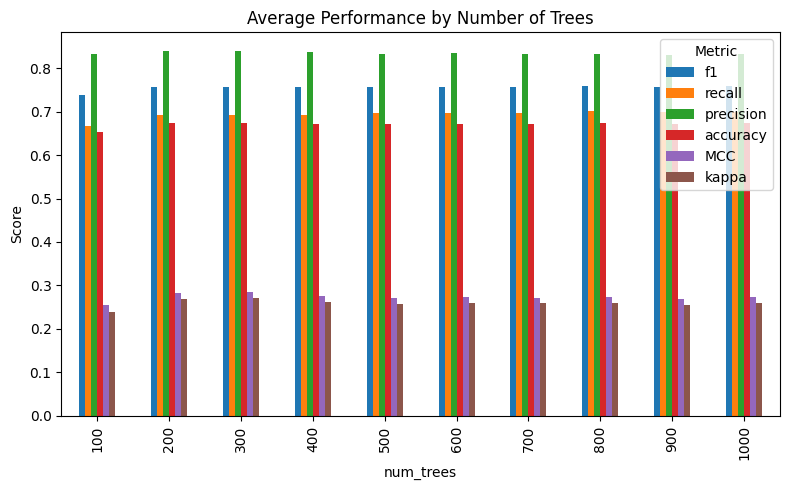

<Figure size 640x480 with 0 Axes>

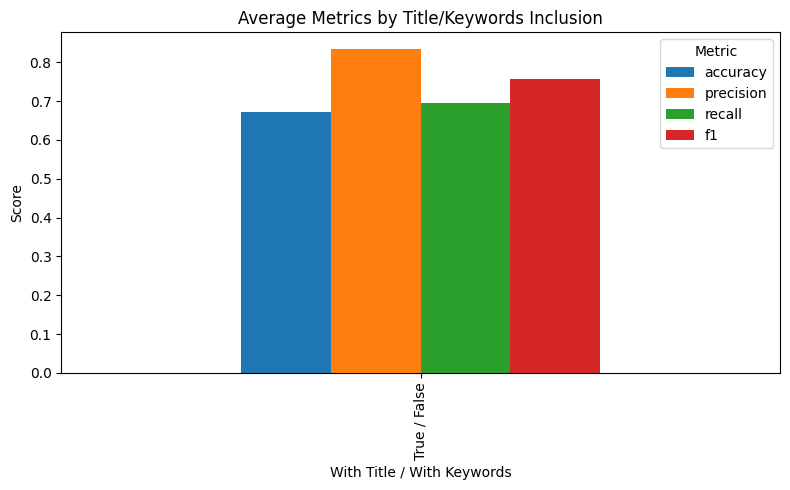

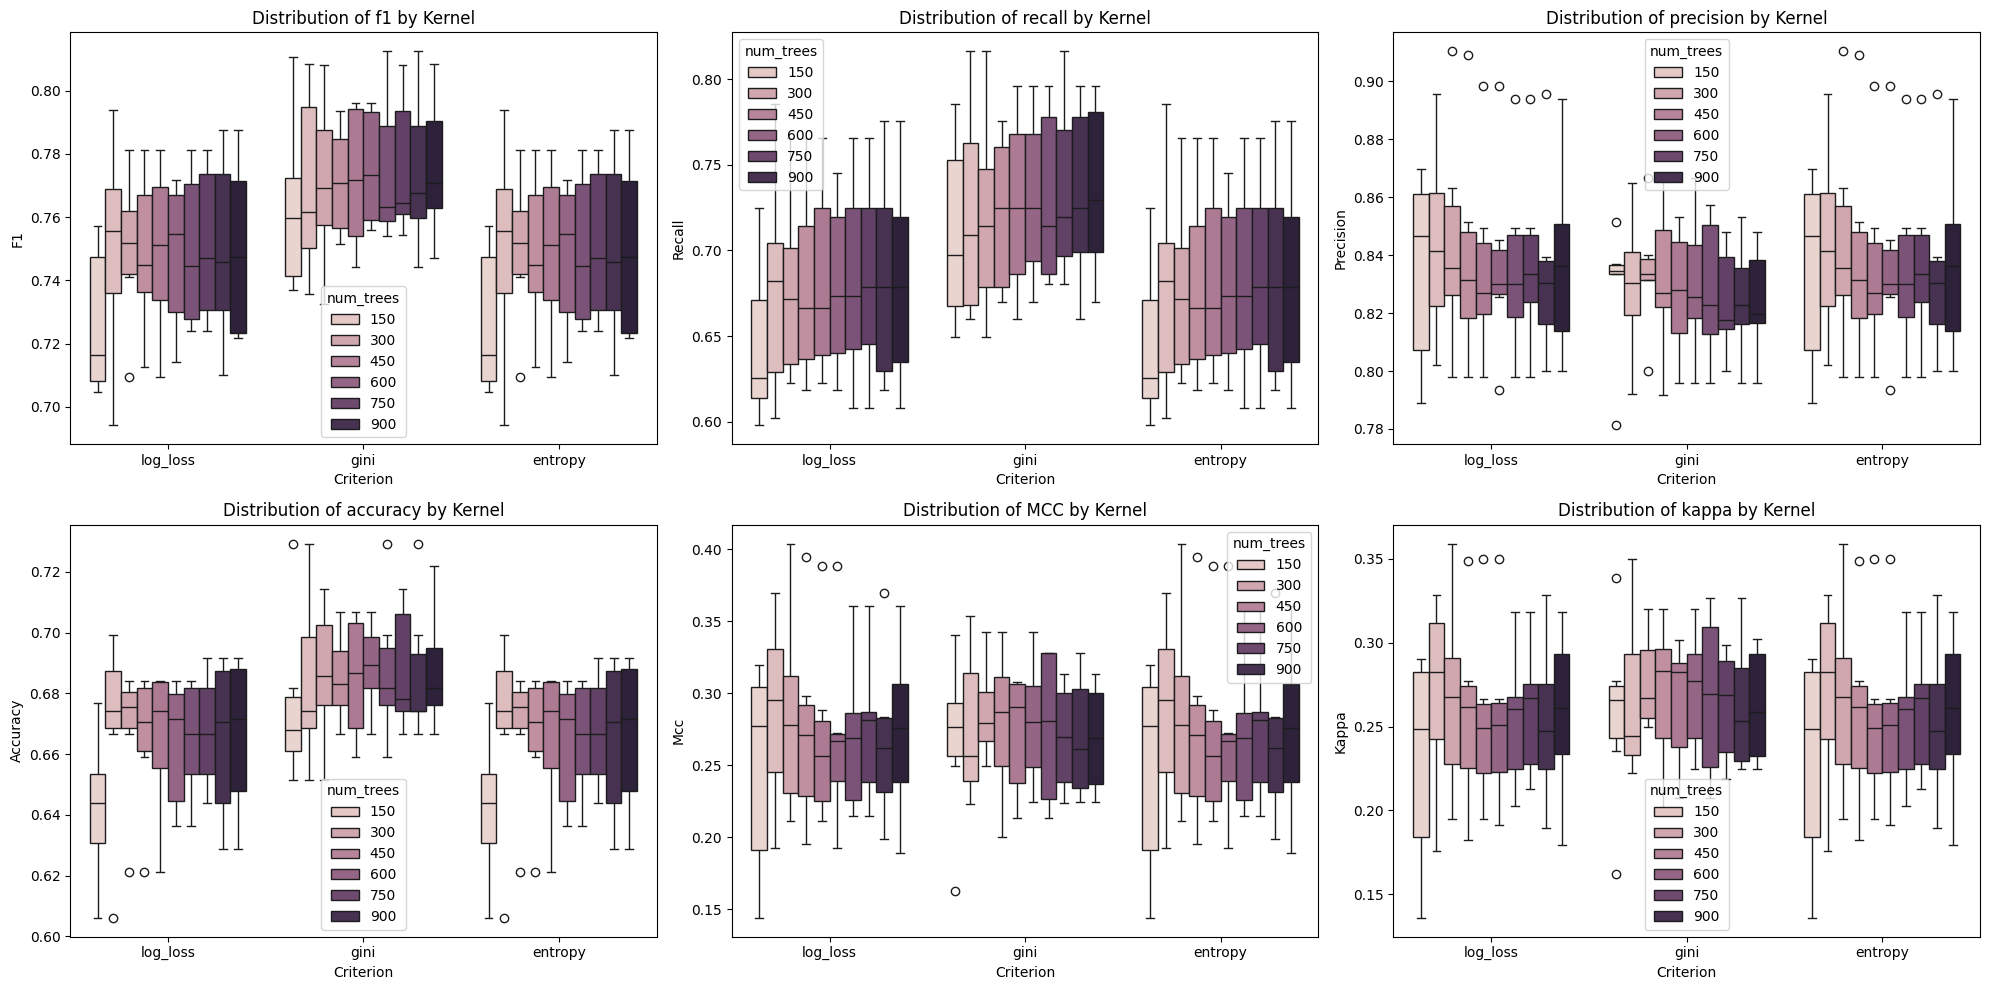

<Figure size 640x480 with 0 Axes>

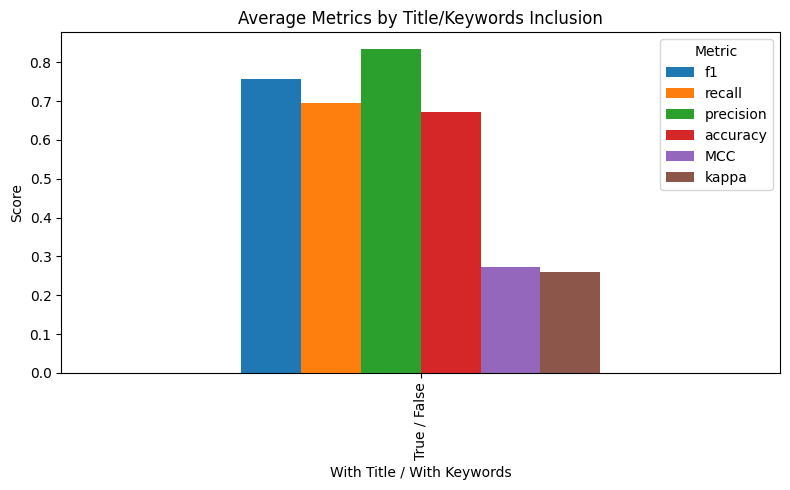

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare the data
df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/random_forest_metrics.csv')
df = df.drop(columns=['Unnamed: 0', 'model_name'])

import matplotlib.pyplot as plt
metrics=['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']
# 1. Average metrics by num_trees
mean_by_trees = df.groupby('num_trees')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()
plt.figure()
mean_by_trees.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance by Number of Trees')
plt.ylabel('Score')
plt.xlabel('num_trees')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 3. Average metrics by Title/Keywords combination
df['title_keywords'] = df['with_title'].astype(str) + ' / ' + df['with_keywords'].astype(str)
mean_by_combo = df.groupby('title_keywords')[['accuracy', 'precision', 'recall', 'f1']].mean()
plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

num_metrics = len(metrics)
n_cols = 3
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax=axes[i]
    sns.boxplot(data=df,x='criterion',y=metric,hue='num_trees',ax=ax)
    ax.set_title(f'Distribution of {metric} by Kernel')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Criterion')
plt.tight_layout()
plt.show()

# 3. Mean metrics by with_title and with_keywords combinations
df['title_keywords'] = df['with_title'].astype(str) + ' / ' + df['with_keywords'].astype(str)
mean_by_combo = df.groupby('title_keywords')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

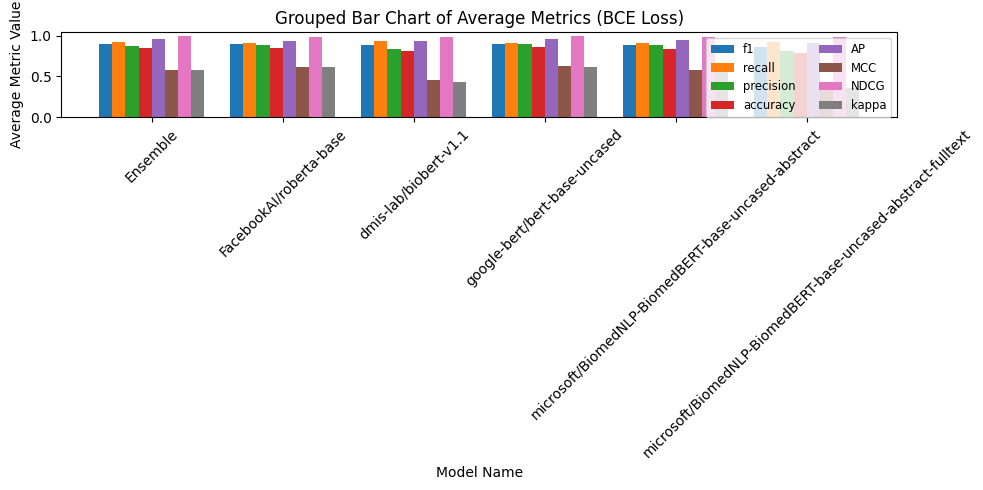

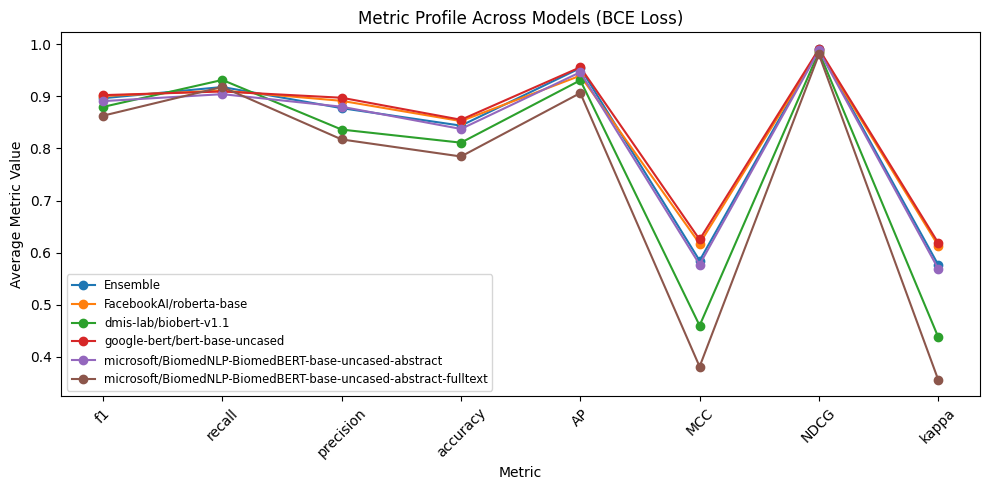

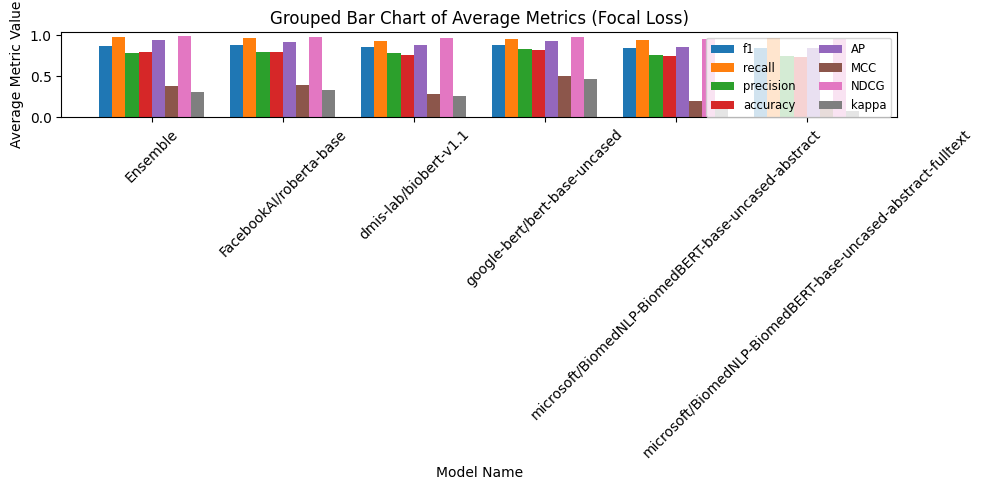

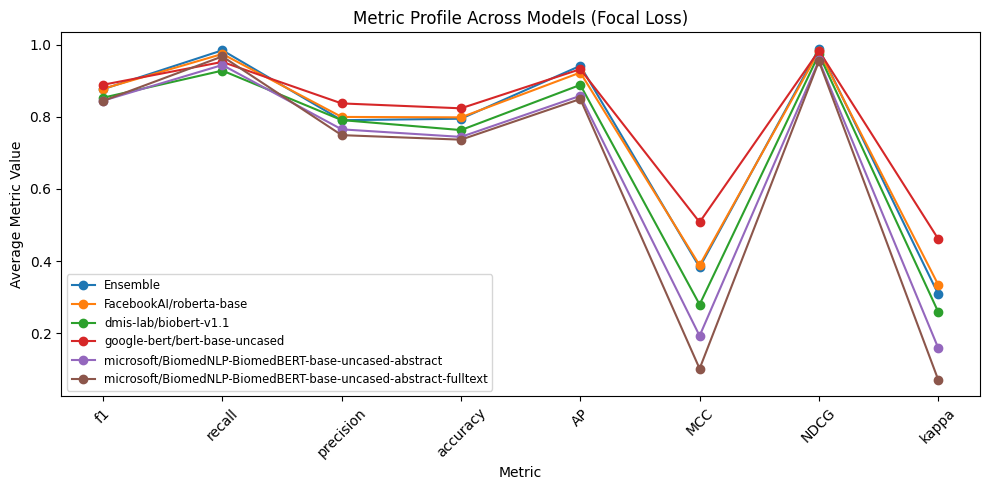

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/binary_metrics.csv'
df = pd.read_csv(file_path)

# Filter out 'focal' and 'BCE' subsets
df_bce = df[df['loss_type'] == 'BCE']
df_focal = df[df['loss_type'] == 'focal']

# Define metric columns to aggregate
metric_cols = ['f1', 'recall', 'precision', 'accuracy', 'AP', 'MCC', 'NDCG', 'kappa']

# Aggregate metrics by model_name for BCE
agg_bce = df_bce.groupby('model_name')[metric_cols].mean().reset_index()

# Aggregate metrics by model_name for focal
agg_focal = df_focal.groupby('model_name')[metric_cols].mean().reset_index()

# Function to plot grouped bar chart and line profile for a given aggregated DataFrame
def plot_metrics(aggregated_df, title_suffix):
    models = aggregated_df['model_name']
    metrics = metric_cols
    x_positions = range(len(models))
    
    # Grouped Bar Chart
    plt.figure(figsize=(10, 5))
    bar_width = 0.1
    for i, metric in enumerate(metrics):
        plt.bar([pos + bar_width * i for pos in x_positions], aggregated_df[metric], width=bar_width, label=metric)
    plt.xticks([pos + bar_width * (len(metrics) - 1) / 2 for pos in x_positions], models, rotation=45)
    plt.xlabel('Model Name')
    plt.ylabel('Average Metric Value')
    plt.title(f'Grouped Bar Chart of Average Metrics ({title_suffix})')
    plt.legend(fontsize='small', ncol=2)
    plt.tight_layout()
    plt.show()
    
    # Line Plot
    x_pos_metrics = range(len(metrics))
    plt.figure(figsize=(10, 5))
    for idx, model in enumerate(models):
        y_vals = aggregated_df.iloc[idx][metrics]
        plt.plot(x_pos_metrics, y_vals, marker='o', label=model)
    plt.xticks(x_pos_metrics, metrics, rotation=45)
    plt.xlabel('Metric')
    plt.ylabel('Average Metric Value')
    plt.title(f'Metric Profile Across Models ({title_suffix})')
    plt.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# Plot for BCE
plot_metrics(agg_bce, "BCE Loss")

# Plot for focal
plot_metrics(agg_focal, "Focal Loss")


## BERT

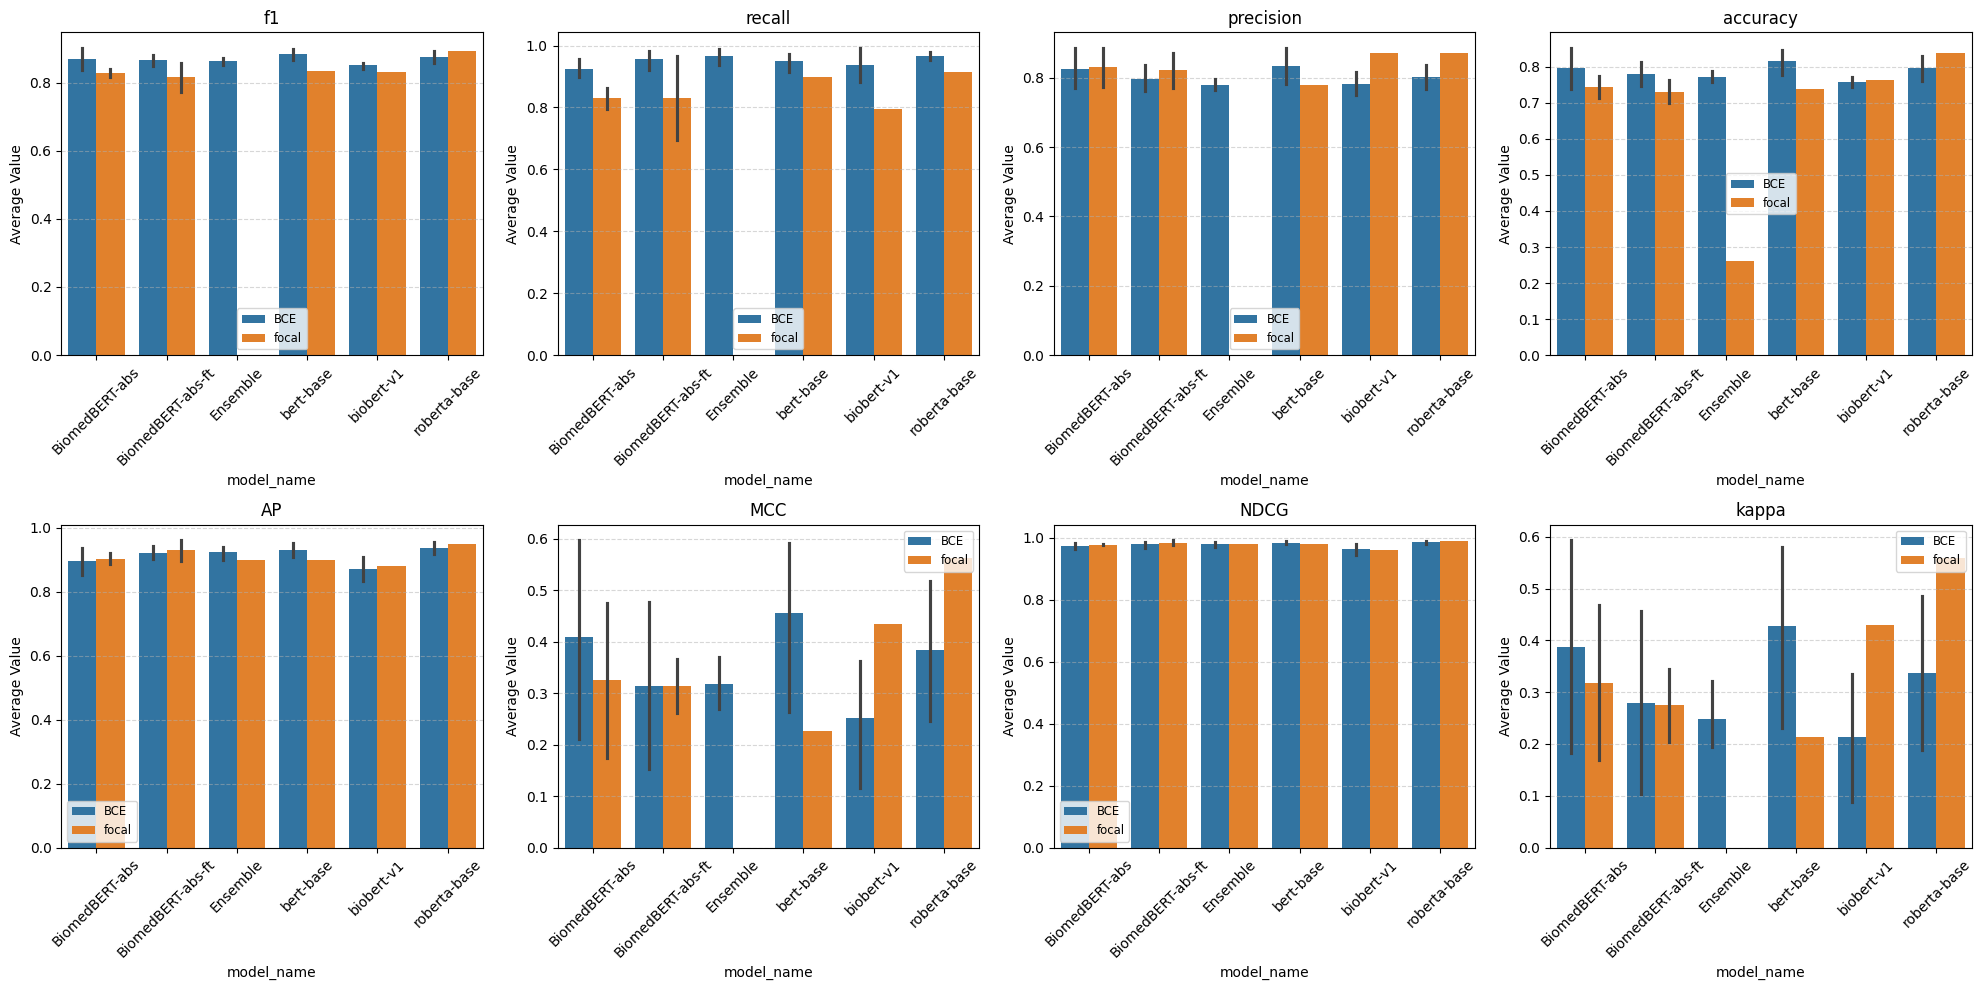

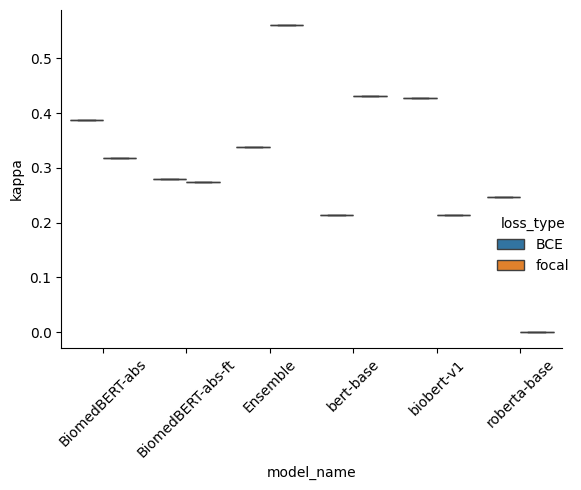

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/binary_metrics.csv'
df = pd.read_csv(file_path)
# Define metric columns to aggregate
metric_cols = ['f1', 'recall', 'precision', 'accuracy', 'AP', 'MCC', 'NDCG', 'kappa']

# Aggregate metrics by model_name, loss_type, and run
agg = df.groupby(['model_name', 'loss_type', 'fold','run'])[metric_cols].mean().reset_index()

# Further aggregate over runs to get a single value per model_name/loss_type
agg_mean = agg.groupby(['model_name', 'loss_type'])[metric_cols].mean().reset_index()

# Pivot to have loss_type as columns for easier plotting
pivoted = agg_mean.pivot(index='model_name', columns='loss_type')[metric_cols]

# For each metric, plot BCE vs focal for each model
num_metrics = len(metric_cols)
n_cols = 4
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metric_cols):
    ax = axes[i]
    bce_vals = pivoted[(metric, 'BCE')]
    x = range(len(bce_vals))
    
    sns.barplot(data=df,x="model_name",y=metric,hue="loss_type",ax=ax)
    
    ax.set_xticks(x)
    ax.set_xticklabels(bce_vals.index, rotation=45)
    ax.set_title(metric)
    ax.set_ylabel('Average Value')
    ax.legend(fontsize='small')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove any unused subplots
for j in range(num_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

sns.catplot(data=agg_mean,x='model_name',y='kappa',hue='loss_type',kind='box')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


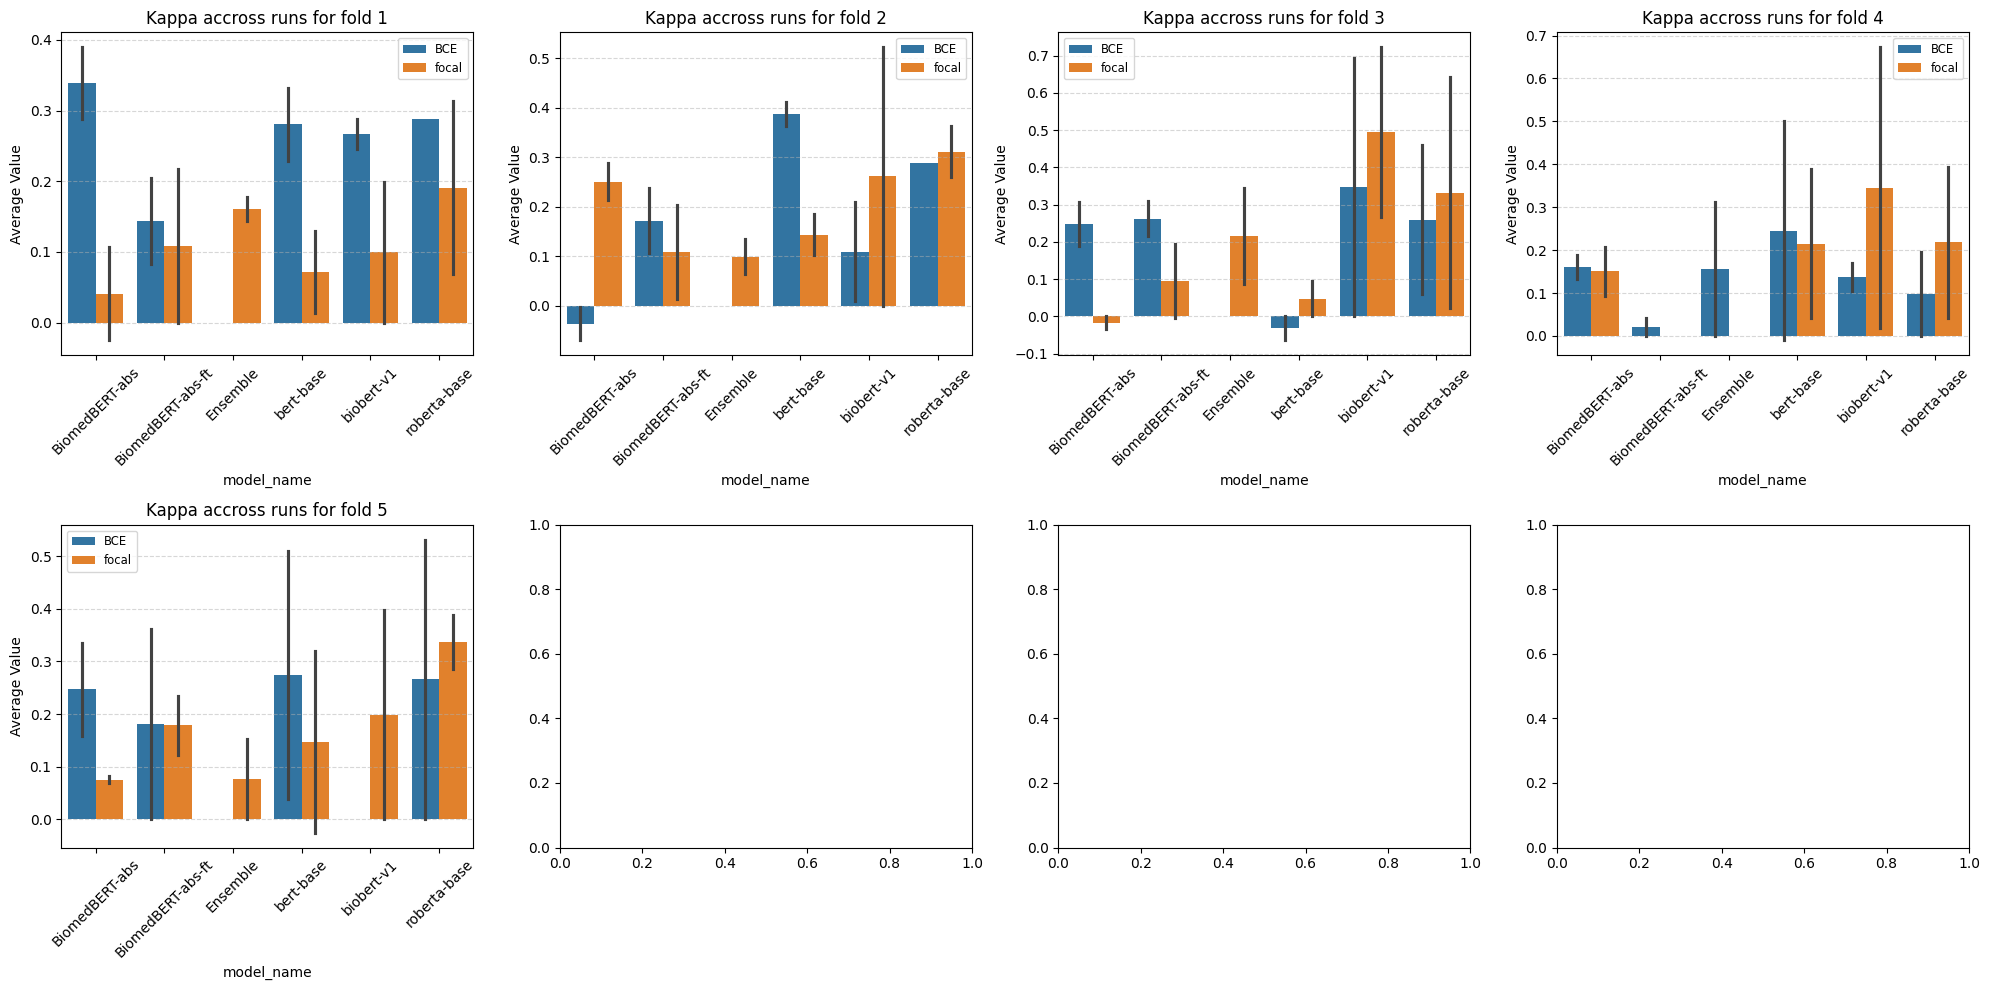

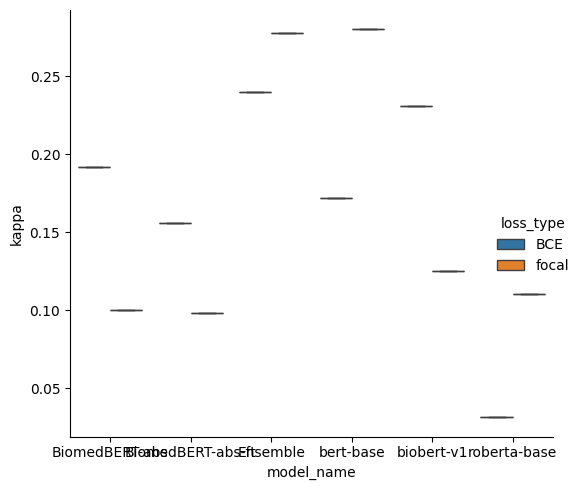

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/metrics/binary_metrics.csv'
df = pd.read_csv(file_path)
df.loc[df['model_name'] == 'Ensemble', 'run'] = df.loc[df['model_name'] == 'Ensemble', 'run'].map({1: 2, 0: 1})

# Define metric columns to aggregate
metric_cols = ['f1', 'recall', 'precision', 'accuracy', 'AP', 'MCC', 'NDCG', 'kappa']

# Aggregate metrics by model_name, loss_type, and run
agg = df.groupby(['model_name', 'loss_type', 'fold'])[metric_cols].mean().reset_index()

# Further aggregate over runs to get a single value per model_name/loss_type
agg_mean = agg.groupby(['model_name', 'loss_type'])[metric_cols].mean().reset_index()

# Pivot to have loss_type as columns for easier plotting
pivoted = agg_mean.pivot(index='model_name', columns='loss_type')[metric_cols]

# For each metric, plot BCE vs focal for each model
num_metrics = len(metric_cols)
n_cols = 4
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

metric="kappa"
for i, fold in enumerate(df["fold"].unique()):
    ax = axes[i]
    bce_vals = pivoted[(metric, 'BCE')]
    x = range(len(bce_vals))
    


    sns.barplot(data=df[df["fold"]==fold],x="model_name",y=metric,hue="loss_type",ax=ax)
    
    ax.set_xticks(x)
    ax.set_xticklabels(bce_vals.index, rotation=45)
    ax.set_title(f"Kappa accross runs for fold {fold}")
    ax.set_ylabel('Average Value')
    ax.legend(fontsize='small')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove any unused subplots
for j in range(num_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

sns.catplot(data=agg_mean,x='model_name',y='kappa',hue='loss_type',kind='box')
plt.tight_layout()
plt.show()


# Statistical Test

## Friedman + Nemenyi

n_folds: 3
Per‐fold recall for each model:

   bert-base-uncased_with_title_with_keywords_run-1.csv  \
1                                                1.0      
2                                                1.0      
3                                                1.0      

   bert-base-uncased_with_title_with_keywords_run-0.csv  \
1                                             1.0000      
2                                             0.9898      
3                                             1.0000      

   BiomedNLP-BiomedBERT-base-uncased-abstract_with_title_run-0.csv  \
1                                             0.8776                 
2                                             0.9592                 
3                                             0.9794                 

   biobert-v1.1_with_title_with_keywords_run-1.csv  \
1                                              1.0   
2                                              1.0   
3                                      

/tmp/ipykernel_23873/1385117876.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


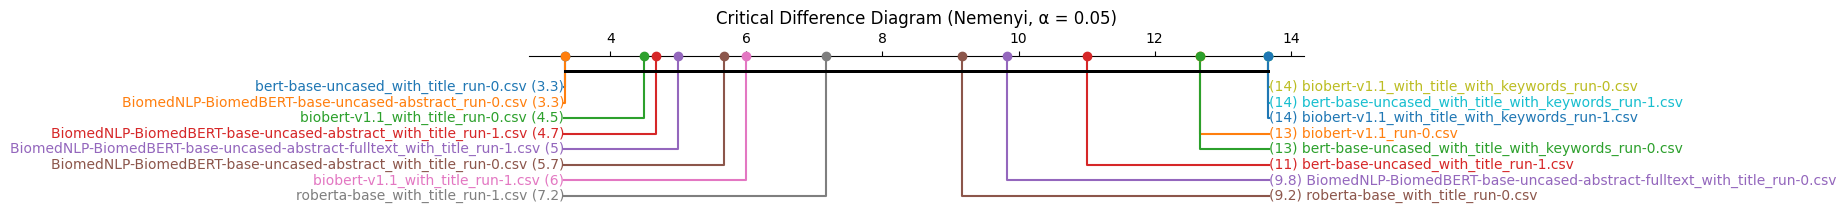

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 1) CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────

# Path containing one CSV per model per CV‐fold.
# e.g.:
#   modelA_fold1.csv, modelA_fold2.csv, …, modelB_fold1.csv, …
DATA_DIR = '/home/leandre/Projects/BioMoQA_Playground/results/biomoqa/test preds'  # adjust as needed

# ─────────────────────────────────────────────────────────────────────────────
# 2) LOAD EACH MODEL’S FOLD‐LEVEL CSVs INTO A DICTIONARY
# ─────────────────────────────────────────────────────────────────────────────

model_data = {}
for model_type in ["bert"]:
    all_files = glob.glob(os.path.join(DATA_DIR, model_type, '*.csv'))
    for fpath in all_files:
        fname = os.path.basename(fpath)
        df = pd.read_csv(fpath)
        # Group by “fold” and store each fold’s DataFrame:
        for fold_idx in df["fold"].unique():
            model_data.setdefault(fname, []).append(df[df["fold"] == fold_idx])

# ─────────────────────────────────────────────────────────────────────────────
# 3) COMPUTE FOLD‐LEVEL METRIC (e.g. RECALL) PER MODEL
# ─────────────────────────────────────────────────────────────────────────────

perf = {}  # perf[model_name] = list of recall scores, one per CV‐fold

for model_name, dfs in model_data.items():
    recalls = []
    for fold_df in dfs:
        r = recall_score(fold_df['label'], fold_df['prediction'])
        recalls.append(r)
    perf[model_name] = recalls

# Build a DataFrame of shape (n_folds × n_models):
if not perf:
    raise ValueError("No performance data found. Check if DATA_DIR contains the expected CSV files.")

n_folds = len(next(iter(perf.values())))
print("n_folds:", n_folds)
fold_idx = list(range(1, n_folds + 1))

perf_df = pd.DataFrame(
    {m: perf[m] for m in perf},
    index=fold_idx
)

print("Per‐fold recall for each model:\n")
print(perf_df.round(4))
print("\n")

# ─────────────────────────────────────────────────────────────────────────────
# 4) FRIEDMAN TEST
# ─────────────────────────────────────────────────────────────────────────────

stat, p_value = friedmanchisquare(*[perf_df[col] for col in perf_df.columns])
print(f"Friedman χ² = {stat:.3f},  p-value = {p_value:.4f}")

if p_value >= 0.05:
    print("→ Friedman test is not significant (p ≥ 0.05). Stop here.")
else:
    print("→ Friedman test is significant (p < 0.05). Proceed to Nemenyi post-hoc.\n")

    # ─────────────────────────────────────────────────────────────────────────
    # 5) NEMENYI POST-HOC (PAIRWISE) TEST
    # ─────────────────────────────────────────────────────────────────────────

    # Pass the entire DataFrame: rows = folds (blocks), columns = models
    nemenyi_pvals = sp.posthoc_nemenyi_friedman(perf_df)
    # Returned DataFrame is already labeled with model names :contentReference[oaicite:2]{index=2}.

    print("Pairwise Nemenyi p-values:")
    print(nemenyi_pvals.round(4))
    print("\n")

    # ─────────────────────────────────────────────────────────────────────────
    # 6) CRITICAL-DIFFERENCE (CD) DIAGRAM
    # ─────────────────────────────────────────────────────────────────────────

    # Compute average ranks: rank each row (fold) across models, then average:
    ranks_df = perf_df.rank(axis=1, method='average')  # shape = (n_folds, n_models)
    avg_ranks = ranks_df.mean(axis=0)                  # pandas Series indexed by model names

    # Plot the CD diagram in one shot:
    plt.figure(figsize=(10, 2), dpi=100)
    plt.title("Critical Difference Diagram (Nemenyi, α = 0.05)")
    sp.critical_difference_diagram(avg_ranks, nemenyi_pvals)
    plt.tight_layout()
    plt.show()
